# Machine Learning: Credit Card Fraud Detection

# Importing packages

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import (classification_report, precision_score, recall_score,
                             average_precision_score, roc_auc_score,
                             f1_score, matthews_corrcoef)
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Importing and exploring dataset

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification. (From https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

There are 284,315 non-fraud transactions and 492 fraud transactions in the dataset.

# Model training with unbalanced weight Logistic Regression

#### Splitting the training and testing datasets

In [5]:
y = df['Class']
X = df.drop(['Class','Amount','Time'], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (256326, 28)
X_test: (28481, 28)
y_train: (256326,)
y_test: (28481,)


This was split 90% training and 10% testing. X datasets have 28 columns each and Y datasets have 1 column (class).

In [7]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
169217,-0.204054,0.773672,-0.508138,-0.504530,1.110237,-0.889531,0.892855,-0.129737,0.067865,-0.706473,...,-0.157602,-0.045248,-0.354026,-0.841090,0.345082,0.463542,-0.357763,0.117770,0.124158,0.049966
127577,1.185899,-0.777605,0.290538,-0.507296,-0.883708,-0.444648,-0.380721,-0.136399,-0.734164,0.441292,...,0.425192,0.249048,0.100304,0.176216,-0.087076,0.117514,0.455406,-0.235654,0.009948,0.026970
155900,0.337897,-0.400062,1.397225,-0.601374,-1.432251,-0.115443,-0.791959,-0.113610,-0.818184,1.161987,...,2.266210,-0.067891,-0.200381,0.177004,0.015208,-0.096025,-0.729801,0.219861,0.203869,0.166661
274954,2.035125,-0.389804,-2.551903,-0.722794,2.380486,3.320923,-0.468416,0.789462,0.402422,0.089469,...,0.020289,-0.138523,-0.288467,-0.839066,0.374619,0.698594,-0.267765,0.218413,-0.053658,-0.065533
250973,1.994644,-0.343013,-0.516240,0.339995,-0.353679,-0.100897,-0.572387,-0.009577,1.255657,-0.167218,...,-0.344320,-0.140784,0.280918,1.054895,0.089021,0.657755,0.014361,-0.165380,0.039714,-0.031416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85418,-1.497933,0.657921,1.581568,-0.024286,0.584698,1.303031,0.609212,0.135561,0.452745,0.108640,...,-1.241768,-0.225079,-0.072452,0.299172,0.110048,-0.615980,-0.425883,0.263968,-0.448445,0.045178
29062,1.069777,0.072105,0.496540,1.505318,-0.380277,-0.370243,0.100551,-0.026687,0.319684,-0.131553,...,-0.500426,-0.149402,-0.061991,-0.044629,-0.050485,0.400171,0.593314,-0.335160,0.031014,0.024886
13766,1.280465,0.300586,0.333044,0.512720,0.065052,-0.145844,-0.145519,-0.091833,1.111187,-0.268878,...,0.278512,-0.093783,-0.409934,-0.961351,0.033153,-0.560429,0.278428,0.089546,-0.059835,-0.005887
17677,-0.598120,0.775041,1.823394,0.312991,-0.096171,-0.391452,0.499351,0.071224,-0.017496,-0.512312,...,-0.238137,0.102259,0.060615,0.568083,-0.084001,0.685003,-0.245859,0.356638,0.378580,0.206366


In [8]:
#### np.where(y_train == 1)[0] returns all of the indexes of fraud transactions in the training dataset
print("Fraud in y_train:", len(np.where(y_train == 1)[0]))
#### np.where(y_test == 1)[0] returns all of the indexes of fraud transactions in the testing dataset
print("Fraud in y_test", len(np.where(y_test == 1)[0]))

Fraud in y_train: 443
Fraud in y_test 49


#### Training and testing the model

In [9]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [10]:
y_pred = model.predict(X_test)
y_pred
# predicted class values for the testing dataset

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
confusion_matrix(y_test, y_pred)
# top left value is number of values in testing dataset that were correctly guessed to be non-fraudulent.
# top right value is number of values in testing dataset that were incorrectly guessed to be fraudulent
# bottom left value is number of values in testing dataset that were incorrectly guessed to be non-fraudulent
# bottom right value is number of values in testing dataset that were correctly guessed to be fraudulent

array([[28426,     6],
       [   15,    34]])

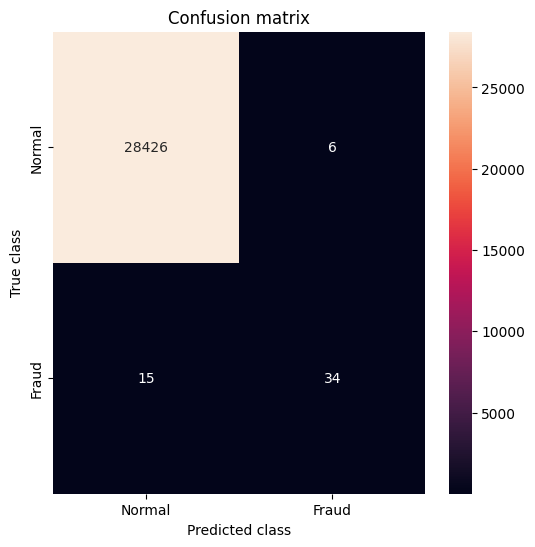

In [12]:
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Model training with default balanced weight Logistic Regression

In [13]:
X = df.drop(['Class','Amount','Time'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [14]:
# balanced mode uses the values of y_train to automatically adjust weights
# inversely proportional to class frequencies in the input data, giving the
# under-represented classes (fraudulent transactions) a higher weighting
# when training the model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [15]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
confusion_matrix(y_test, y_pred)

array([[27657,   775],
       [    4,    45]])

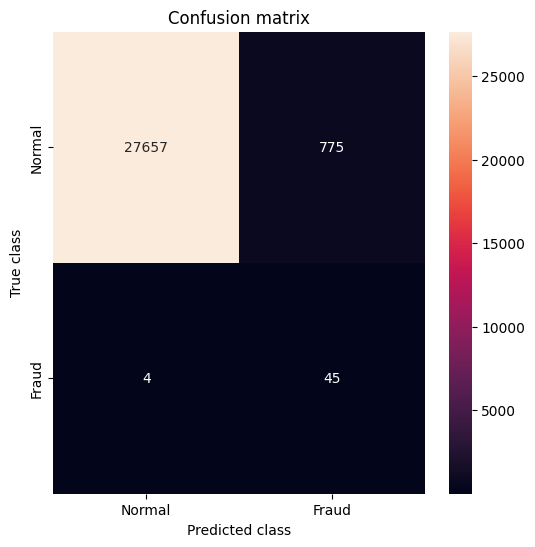

In [17]:
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

The model detected significantly more fraud and false positives due to the weighting for fraudulent transactions being too high.

# Model training with custom balanced weight Logistic Regression

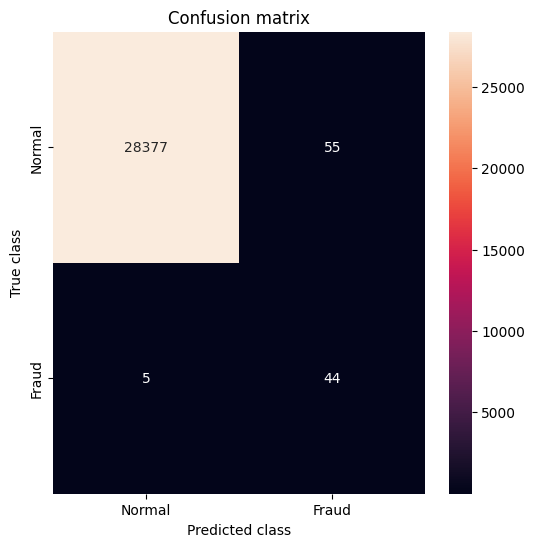

In [18]:
# using custom class weights in order to lower the number of false positives detected
model = LogisticRegression(class_weight={0:1, 1:50})
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Less false positives now due to weighting for fraudulent transactions having been brought down

In [19]:
model.classes_

array([0, 1])

In [20]:
# y = mx + b
model.coef_

array([[ 0.11077592, -0.06859069, -0.01967696,  0.88409344,  0.09144915,
        -0.18473897,  0.05203225, -0.36027874, -0.1543006 , -0.61276151,
         0.23644341, -0.58795584, -0.39928999, -0.67522941, -0.11132962,
        -0.42065113, -0.09667066, -0.03722182, -0.09650186, -0.12984166,
         0.29407768,  0.52342799, -0.18790098,  0.00292142,  0.00887645,
        -0.42029811, -0.13369595,  0.03408903]])

In [21]:
# y = mx + b
model.intercept_

array([-5.61540575])

In [22]:
# Displays the probabilities of the transaction being a part of each class
# [[prob non-fraud, prob fraud],...]
model.predict_proba(X_test)

array([[0.98667522, 0.01332478],
       [0.99558961, 0.00441039],
       [0.99587779, 0.00412221],
       ...,
       [0.99220802, 0.00779198],
       [0.99792357, 0.00207643],
       [0.994318  , 0.005682  ]])

# SHAP
The Shapley value is the average expected marginal contribution of one feature after all possible feature combinations have been considered.

In [23]:
shap.initjs()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


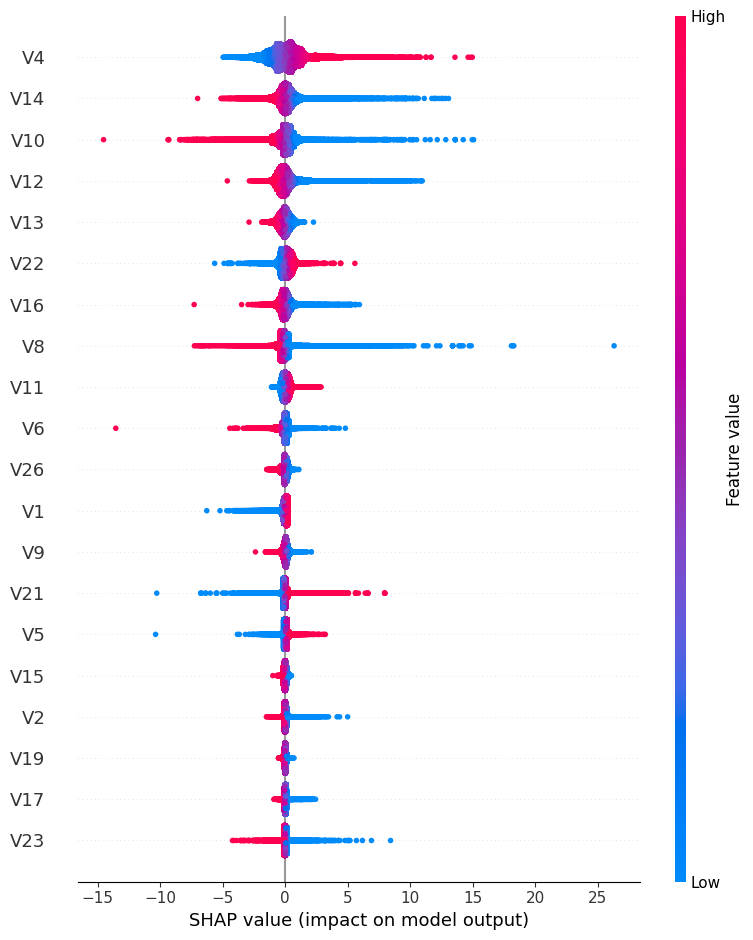

In [24]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

The most significant value is at the top (V4) and then get less important as you go down. This plot is interpreted as V4 contributing significantly positively to the model output (higher V4 = higher prediction), and V14 contributing significantly negatively to the model output (lower V14 = higher prediction)

# Model training with unbalanced weight XGBoost

In [25]:
y = df['Class']
X = df.drop(['Class','Amount','Time'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

#### Using XGBoost to train the model

In [26]:
# XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm.
# Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target
# variable by combining the estimates of a set of simpler, weaker models.
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [27]:
y_pred = model.predict(X_test)

In [28]:
confusion_matrix(y_test, y_pred)

array([[28430,     2],
       [    9,    40]])

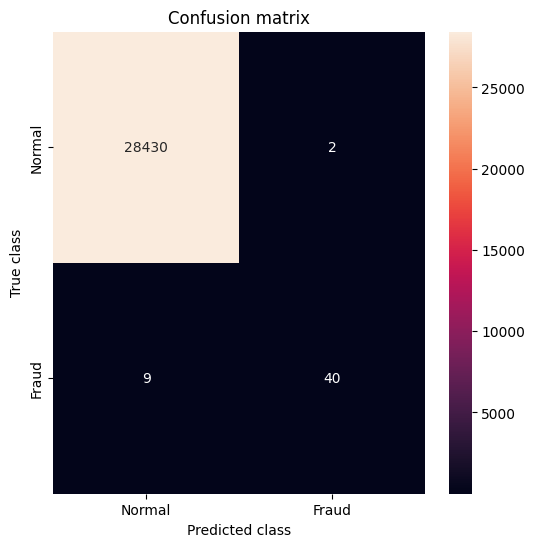

In [29]:
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

There are significantly less false positives now, however the number of fraudulent transactions missed is higher.

# Model training with balanced weight XGBoost

In [30]:
y = df['Class']
X = df.drop(['Class','Amount','Time'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [31]:
# this scale_pos_weight hyperparameter is like the class_weight hyperparameter from
# the logistic regression model where it tells the model to weigh the positive
# class (fraudulent transactions) more by a factor of 100
model = xgb.XGBClassifier(scale_pos_weight=100)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
confusion_matrix(y_test, y_pred)

array([[28427,     5],
       [    8,    41]])

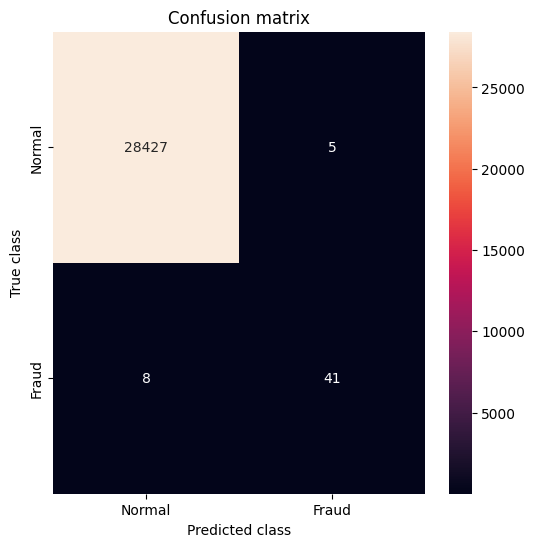

In [34]:
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

There are now slightly less number of fraudulent transactions missed, however the number of false positives went slightly higher as well.

# Model training with balanced weight and specified depth XGBoost

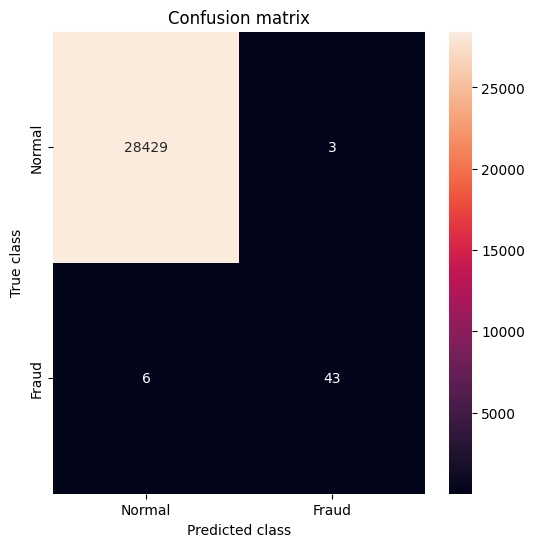

In [35]:
# max_depth hyperparameter represents the maximum depth each of the smaller
# trees in the model will go (prevents overfitting)
model = xgb.XGBClassifier(max_depth=5, scale_pos_weight=100) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

There are now less false positives and less missed fraudulent transactions

In [36]:
model.classes_

array([0, 1])

In [37]:
# this attribute allows you to inspect the model coefficients or the
# most important features in the model
model.feature_importances_

array([0.01778892, 0.006522  , 0.01161652, 0.04864641, 0.00839465,
       0.01592866, 0.02007158, 0.02973094, 0.00941193, 0.04264095,
       0.01003185, 0.02240502, 0.01880649, 0.52212244, 0.01488954,
       0.00652269, 0.08942025, 0.00986922, 0.01701785, 0.01133021,
       0.01525105, 0.0066182 , 0.01258562, 0.00372731, 0.00570192,
       0.01185634, 0.00590739, 0.00518408], dtype=float32)

In [38]:
# Precision is the proportion of correctly predicted fraudulent instances among all instances predicted as fraud
# (# of True Positives)/(# of True Positives + # of False Positives)
precision_score(y_test, y_pred)

0.9347826086956522

In [39]:
# Recall is the proportion of the fraudulent instances that are successfully predicted
# (# of True Positives)/(# of True Positives + # of False Negatives)
recall_score(y_test, y_pred)

0.8775510204081632

In [40]:
# F1-score is the harmonic balance of precision and recall (can be weighted more towards P or R if need be)
# 2 * (Precision * Recall)/(Precision + Recall)
f1_score(y_test, y_pred)

0.9052631578947369

In [41]:
# AUROC/AUC = Area under the Receiver Operating Characteristic curve
# plot the TPR (Recall) and FPR at various classification thresholds
# FPR = (# of False Positives)/(# of False Positives + # of True Negatives)
roc_auc_score(y_test, y_pred)

0.9387227527476945

AUPRC can be thought of as the accurancy at which the model is able to identify fraudulent and non-fraudulent transactions correctly.

In [42]:
# AUPRC = Area under the Precision-Recall curve
# Better alternative to AUC as doesn't include TN which influences the scores significantly in highly imbalanced data
# calculates the area under the curve at various classification thresholds
average_precision_score(y_test, y_pred)

0.8205300988809707

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.93      0.88      0.91        49

    accuracy                           1.00     28481
   macro avg       0.97      0.94      0.95     28481
weighted avg       1.00      1.00      1.00     28481



In [44]:
y = df['Class']
X = df.drop(['Class','Amount','Time'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
model_xgb = xgb.XGBClassifier(max_depth=5, scale_pos_weight=100)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[28429,     3],
       [    6,    43]])

In [45]:
# probability of each transaction being fraudulent
y_pred = model_xgb.predict_proba(X_test)[:,1]
y_pred

array([1.0238165e-05, 1.4227397e-05, 5.2480987e-06, ..., 2.7707663e-06,
       1.6304925e-06, 8.0974127e-07], dtype=float32)

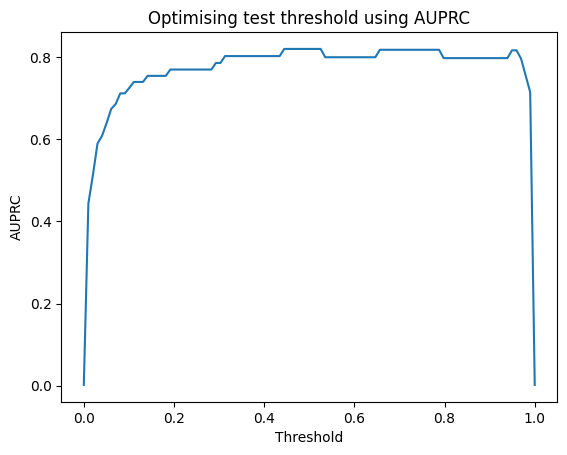

In [53]:
# this code classifies any score above the threshold as fraudulent and any score below the
# threshold as non-fraudulent
# creates one list of thresholds and one list of their individual AUPRCs and combines them
threshold_list = []
auprc_list = []
# np.linspace(0,1,100) returns an array of 100 linearily (equally) spaced values between 0 and 1
thresholds = np.linspace(0, 1, 100)
for threshold in thresholds:
    y_pred_thresh = [1 if e > threshold else 0 for e in y_pred]
    threshold_list.append(threshold)    
    # AUPRC
    auprc_score = average_precision_score(y_test, y_pred_thresh)
    auprc_list.append(auprc_score)
# plot curve
threshold_df = pd.DataFrame(threshold_list, auprc_list).reset_index()
threshold_df.columns = ['AUPRC', 'Threshold']
plt.plot(threshold_df['Threshold'], threshold_df['AUPRC'])
plt.title("Optimising test threshold using AUPRC")
plt.xlabel('Threshold')
plt.ylabel('AUPRC')
plt.savefig('Optimising threshold using AUPRC');
plt.show()

This tells us the best threshold to use in order to maximize accuracy, the best threshold(s) would be to use the ones with the highest AUPRC.

In [54]:
threshold_df.sort_values(by='AUPRC', ascending=False)

,AUPRC,Threshold
50,0.820530,0.505051
44,0.820530,0.444444
52,0.820530,0.525253
51,0.820530,0.515152
48,0.820530,0.484848
...,...,...
3,0.589815,0.030303
2,0.513295,0.020202
1,0.444110,0.010101
0,0.001720,0.000000


In [55]:
# only looking at the significant ones
threshold_df.loc[(threshold_df['AUPRC'] >= 0.82)]

,AUPRC,Threshold
44,0.82053,0.444444
45,0.82053,0.454545
46,0.82053,0.464646
47,0.82053,0.474747
48,0.82053,0.484848
49,0.82053,0.494949
50,0.82053,0.505051
51,0.82053,0.515152
52,0.82053,0.525253


The best threshold to use would be approximately 0.50.